In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer # fazer a transformação de colunas
from sklearn.dummy import DummyRegressor # regressor padrão para comparação
from sklearn.linear_model import ElasticNet, LinearRegression # modelo de regressão
from sklearn.pipeline import Pipeline # criar pipeline, etapa de processamento
from sklearn.preprocessing import (
    OrdinalEncoder, # variáveis ordinais
    OneHotEncoder, # categóricas
    PolynomialFeatures, # criar variáveis com multiplicação entre ela ou ao quadrado dela mesma 
    PowerTransformer, # transformação em potência (yeo-johnson ou box-cox)
    RobustScaler, 
    StandardScaler, # ajuste de escala das variáveis independentes
    QuantileTransformer, # normaliza os dados em quantis
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

        Analisando as informações da base de dados, notamos que dentre todas as colunas apenas duas são categóricas, são elas ocean_proximity e median_income_cat, uma sendo categórica nominal e outra categórica ordinal. A coluna median_income_cat possui o tipo int64, porque o formato parquet reconheceu que apesar da transformação da coluna em tipo catergory, as categorias são númerosm, com isso, ele atribui o tipo para inteiro.

Criando um pré-processamento com as colunas categóricas:
- `ocean_proximity` - coluna categórica nominal, que classifica a distância das casas para o mar. Como não é possível passar texto para o modelo, é necessário fazer um pré-processamento nessa coluna. 
- `median_income_cat` - coluna categórica ordinal, existe um ordenamento nas classes com base na renda por bloco de casas, as faixas de valores estão em categoria de forma crescente entre 1 e 5.

É ideal pegar o modelo mais simples, fazer o mínimo de pré-procesamento para saber se o modelo tem um desempenho melhor que o DummyRegressor. Caso o modelo simples não seja melhor que o Dummy, provavelmente nem valeria a pena continuar para um modelo mais complexo.

In [4]:
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"]

coluna_ordinal_encoder = ["median_income_cat"]

In [5]:
# OrdinalEncoder(categories="auto") - esse parâmetro serve para pegar automaticamente,
# a partir dos dados, quais as categorias da coluna selecionada, esse parâmetro é adequado
# para categorias expresadas em números, quando for string o ideal é passar uma
# lista com as strings de cada categoria presente na coluna
preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot_encoder", OneHotEncoder(drop="first"), coluna_one_hot_encoder)
    ],
    remainder="passthrough" # para não alterar as demais colunas, apenas as selecionadas
)

In [6]:
# separando X e y da base de dados
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [7]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [8]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


Com base no primeiro notebook, 01-jb-eda, podemos notar que no pairplor, a distribuição da coluna `median_house_value (target)` apresenta assimetria, devido a essa assimetria, será realizada uma transformação na coluna target com a função PowerTransformer. Para melhor análise, 3 modelos serão treinados.

Os três modelos treinados serão:
- DummerRegressor, modelo de teste que por padrão chuta a média de tudo;
- LinearRegression com pré-processamento simples, apenas com colunas categóricas, sem usar transformação de target;
- LinearRegression com pré-processamento simples, apenas com colunas categóricas, usando transformação de target.

Verificaremos se existem alguma diferença, porque dependendo do resultado pode ser descartado fazer uma transformação de target posteriormente, se o resultado da transformação de target apresentar alguma melhora, mesmo que leve, podemos procurar outras transformações de target posteriormente como, por exemplo, o QuantileTransformer.

In [9]:
target_transformer = PowerTransformer()

# dicionário de regressores, cada chave é o nome do modelo
regressors = {
    "DummyRegressor":{
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    
    "LinearRegression":{
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },

    "LinearRegression_target":{
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": target_transformer,
    },
}

In [10]:
# criando um dicionário com os resultados dos modelos
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

# transformando o dicionário dos resultados em DataFrame
df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.004885,0.003023,-0.000081,-77516.042766,-96239.705692,0.007908
1,DummyRegressor,0.002087,0.001519,-0.000146,-75787.787194,-95217.629397,0.003606
2,DummyRegressor,0.000999,0.003001,-0.001737,-76753.598961,-96253.253947,0.004001
3,DummyRegressor,0.00147,0.002,-0.000101,-76837.804811,-95983.885799,0.00347
4,DummyRegressor,0.002,0.002001,-0.000114,-76617.245449,-96182.764729,0.004
5,LinearRegression,0.112421,0.007591,0.682162,-39855.690921,-54254.958115,0.120012
6,LinearRegression,0.011278,0.004005,0.66999,-40272.565406,-54695.230224,0.015283
7,LinearRegression,0.015363,0.006007,0.649247,-42178.059246,-56955.988686,0.02137
8,LinearRegression,0.01376,0.005749,0.669873,-40806.492452,-55146.31876,0.019508
9,LinearRegression,0.007749,0.009869,0.669023,-40788.496555,-55331.351171,0.017618


In [11]:
# agrupando os DataFrame de resultados pelo nome do modelo e exibindo a média de seus valores para cada coluna
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.002288,0.002309,-0.000436,-76702.495836,-95975.447913,0.004597
LinearRegression,0.032114,0.006644,0.668059,-40780.260916,-55276.769391,0.038758
LinearRegression_target,0.017893,0.006206,0.671185,-38909.258354,-55011.704371,0.024099


        Comparando os modelos de LinearRegression com e sem transformação de target. O modelo com transformação de target apresenta um ganho de desempenho em R² (+), no MAE teve uma melhora (-), no RMSE teve uma leve melhora (-) também, em quentão de Tempo(s) teve uma grande difença, o modelo com transformação de target demorou um pouco mais para ser treinado.

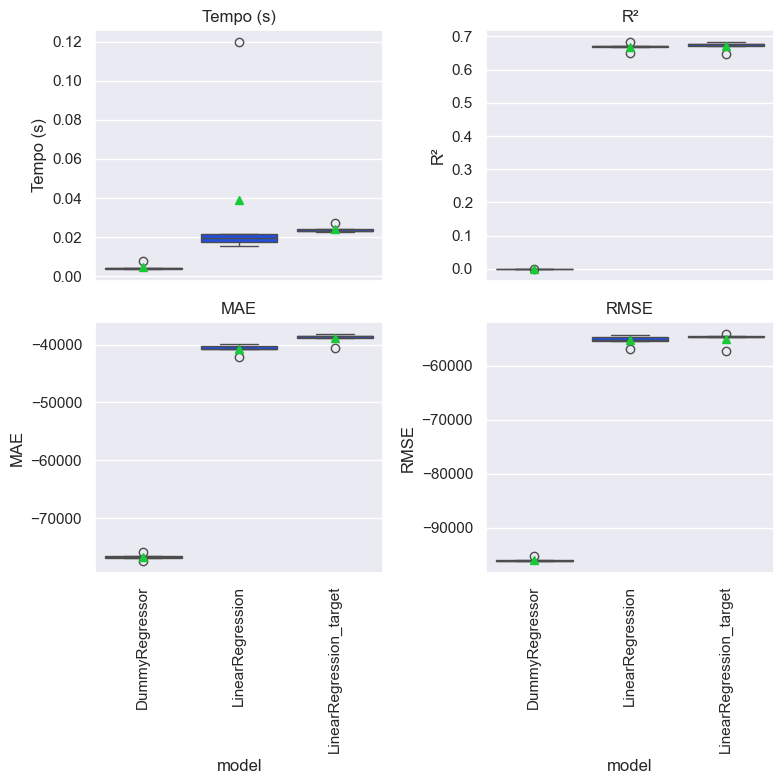

In [12]:
# criando boxplots para representar a comparação do desempenho dos modelos
plot_comparar_metricas_modelos(df_resultados)

        No boxplot de tempo é notável a diferença entre os modelos, considerando que para a transformação de target é realizada uma validação cruzada, realizada 5 vezes, deixando o modelo um pouco mais lento. No R² tivemos uma leve difença, as linhas estão bem próximas entre os modelos, mas a transformação de target apresenta um desempenho um pouquinho melhor. Em MAE existe uma diferença significativa, quanto menor melhor. O RMSE parece ter uma mediana melhor, mas tem outlier que joga a média para baixo. Com isso, parece valer a pena fazer a transformação de target.
       Agora, será que realizando pré-processamentos mais especializados para cada tipo de coluna teremos uma melhoria das métricas do modelo em geral? Em relação ao DummyRegressor, ambos os modelos apresentam desempenho melhor do que apenas chutar a média.

Como na comparação de modelos, verificamos o desempenho, parece que vale a pena fazer a transformação de target. A partir disso, será realizada a comparação de transformação de target entre PowerTransformer e QuantileTransformer por meio de grid_search.

In [13]:
# será realizada a comparação entre nenhum transformer, PowerTransformer e QuantileTransfomer
# (nenhuma transformação, transformação em potência e transformação em quantis para distribuição normal)
param_grid = {
    "transformer": [None, PowerTransformer(), QuantileTransformer(output_distribution="normal")], # parâmetro transformer
}

In [14]:
# criando uma pesquisa de grade para saber qual transformação apresenta o melhor resultado
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(), # o modelo
    preprocessor=preprocessamento, # pré-processamento
    target_transformer=target_transformer, # PowerTransformer guardado na variável 
    param_grid=param_grid, # parâmetro para transformar o target
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-1,
             param_grid={'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [15]:
# treinando o grid_search
grid_search.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-1,
             param_grid={'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [16]:
grid_search.best_params_

{'transformer': QuantileTransformer(output_distribution='normal')}

        A transformação de target por QuantileTransformer foi adotada com um melhor desempenho, com apresentado no parâmetro "transformer" no treinamento do modelo.

Verificando e comparando as métricas da última com a penúltima comparação

In [17]:
# métrica RMSE (Root Mean Square Error - raiz do erro quadrático médio)
# é a métrica de desempate no refit de validação cruzada da função grid_search_cv_regressor
grid_search.best_score_

np.float64(-54415.54744045464)

Analisando os coeficientes

In [18]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out()
)

coefs

,coeficiente
one_hot_encoder__ocean_proximity_INLAND,-0.451774
remainder__longitude,-0.293641
remainder__latitude,-0.286735
remainder__population_per_household,-0.279342
one_hot_encoder__ocean_proximity_NEAR BAY,-0.203196
one_hot_encoder__ocean_proximity_NEAR OCEAN,-0.059181
remainder__total_bedrooms,-0.000233
remainder__total_rooms,-0.000059
remainder__population,-0.000037
remainder__households,0.000859


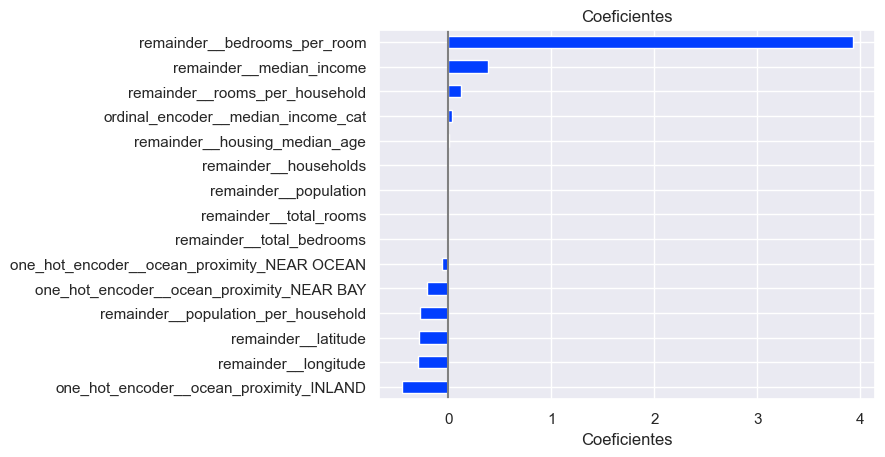

In [19]:
# criando um gráfico com os coeficientes
plot_coeficientes(coefs)

        Entre os coeficientes positivos, a coluna bedrooms_per_room (quartos por cômodo) é a mais significativa, apresentando uma diferença bem grande em comparação com as demais. Em linha intermediária, aparentemente, muitas variáveis estão com coeficientes próximos de zero, indicando que não têm tanta relevância para o resultado do modelo. Por último, a coluna ocean_proximity_INLAND é a mais significativa entre os coeficientes negatos.

Comparando as métricas dos modelos criados até o momento

In [20]:
# separando os processamentos de PowerTransformer e QuantileTransformer
# no modelo de target_quantile - pegaremos o melhor preprocessor, regressor e transformer do grid_search
regressors = {
    "DummyRegressor":{
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    
    "LinearRegression":{
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },

    "LinearRegression_target_power":{
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": target_transformer,
    },
    
    "LinearRegression_target_quantile":{
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}

# criando um dicionário com os resultados dos modelos
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

# transformando o dicionário dos resultados em DataFrame
df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.002005,0.003089,-0.000081,-77516.042766,-96239.705692,0.005094
1,DummyRegressor,0.00205,0.0,-0.000146,-75787.787194,-95217.629397,0.00205
2,DummyRegressor,0.0,0.0,-0.001737,-76753.598961,-96253.253947,0.0
3,DummyRegressor,0.0,0.009447,-0.000101,-76837.804811,-95983.885799,0.009447
4,DummyRegressor,0.001998,0.002,-0.000114,-76617.245449,-96182.764729,0.003999
5,LinearRegression,0.010128,0.004947,0.682162,-39855.690921,-54254.958115,0.015074
6,LinearRegression,0.013542,0.005534,0.66999,-40272.565406,-54695.230224,0.019076
7,LinearRegression,0.010154,0.004998,0.649247,-42178.059246,-56955.988686,0.015153
8,LinearRegression,0.002607,0.0,0.669873,-40806.492452,-55146.31876,0.002607
9,LinearRegression,0.025578,0.006583,0.669023,-40788.496555,-55331.351171,0.032161


In [21]:
# agrupando por modelo e apresentando a média de cada variável
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.001211,0.002907,-0.000436,-76702.495836,-95975.447913,0.004118
LinearRegression,0.012402,0.004413,0.668059,-40780.260916,-55276.769391,0.016814
LinearRegression_target_power,0.016838,0.002751,0.671185,-38909.258354,-55011.704371,0.019589
LinearRegression_target_quantile,0.015553,0.004145,0.677979,-38679.755378,-54440.830718,0.019698


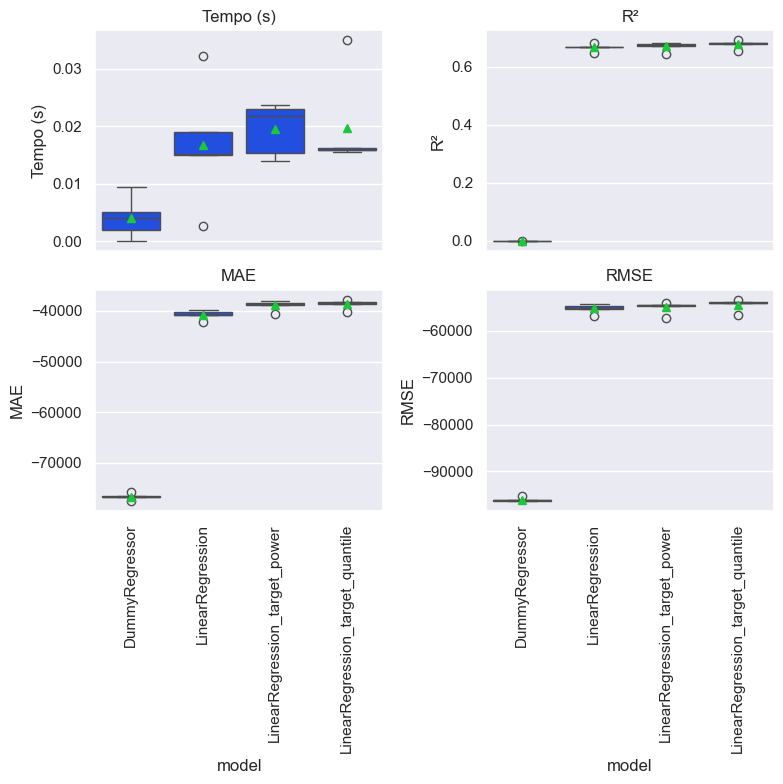

In [22]:
# criando um gráfico com a comparação dos modelos
plot_comparar_metricas_modelos(df_resultados)

        Uma leve melhora é apresentada nos coeficientes do QuantileTransformer em relação ao PowerTranformer, a melhora significativa foi apresentada no tempo de treinamento. O ganho de tempo e melhora nos coeficientes indica que poderíamos excluir o PowerTransformer dos próximos treinamentos, contando que o QuantileTransfomer indica uma superioridade de desempenho gastando menos tempo para treinar.

Verificando os resíduos

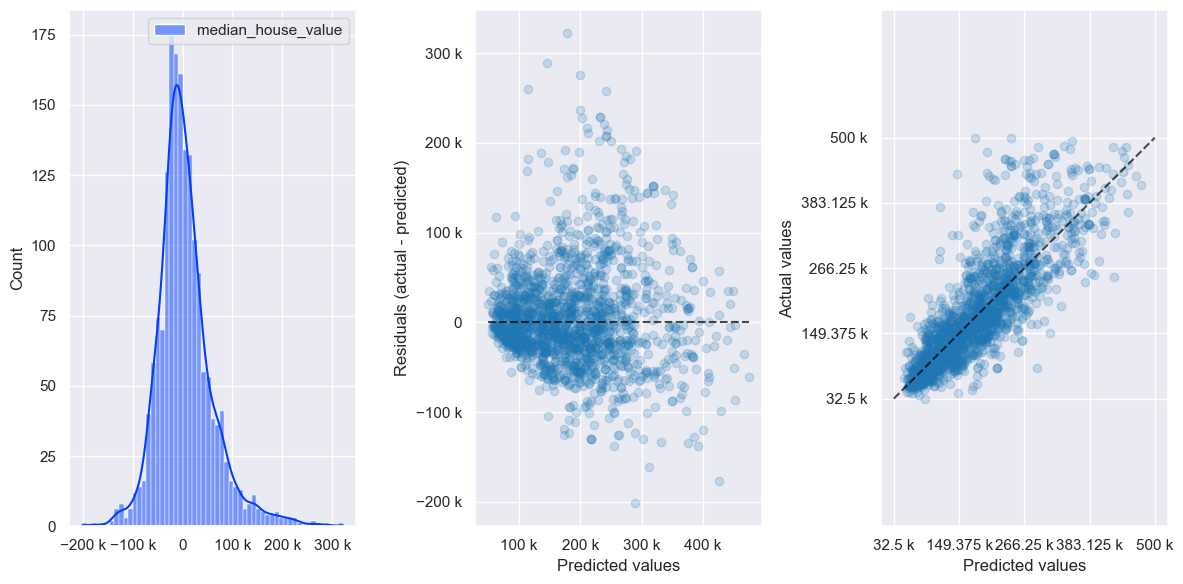

In [23]:
# a função é específica para receber um estimador do grid_search e os parâmetros de treinamento
# o parâmetro fracao_amostra=float serve para exibir a proporção dos dados em relação ao total
# por exemplo, 0.25 significa usar 25% da base total
# esse parâmetro serve para economizar recursos, dependendo da base de dados
# o parâmetro eng_formater ajusta a escala de valores, por exemplo, de 20.000 para 20 k
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)

        O gráfico de resíduos serve para saber se o modelo está errando mais para valores positivos ou negativos, intermediários, menores ou maiores. Para isso, com uma fração dos dados é possível ter uma noção dos erros do modelo. O uso do alpha na função ajuda na visualização de acúmulo dos pontos, por mais que o modelo erre algumas vezes, o ideal é que a maioria dos pontos esteja próximo da reta. 
        Nosso target usa uam faixa de valores muito grande, nosso modelo pode acabar errando devida a faixa de valores muito grande, podemos notar que a faixa de valores é de 100.000, o que realmente importa é que os pontos estejam o mais próximo da reta. POdemos notar que o modelo está errando um pouco mais para valores positivos do que negativos, pela faixa de valor é notável, aparentemente, o modelo tem tendência de errar para menos, valores muito altos o modelo não consegue prever ainda.